<a href="https://colab.research.google.com/github/TobyM27/Tugas-Besar-Kriptografi/blob/main/TugasBesar_Kriptografi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

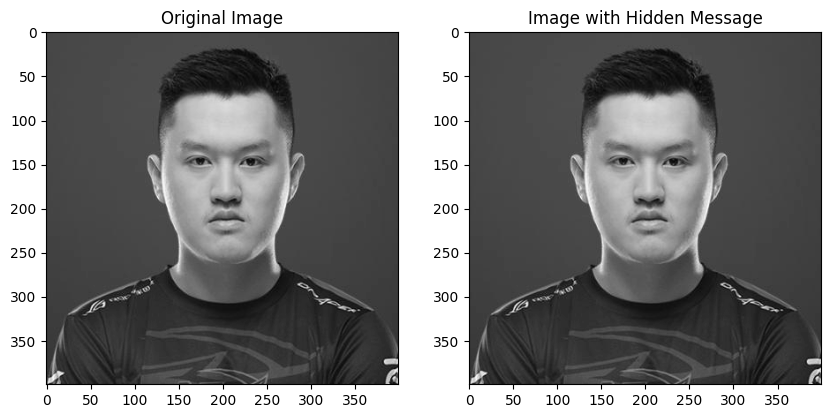

Decrypted Message: Hello, ElGamal!


In [ ]:
import numpy as np
from PIL import Image
import random
from sympy import isprime, mod_inverse
import matplotlib.pyplot as plt

# Implementasi fungsi BPCS
def calculate_complexity(block):
    return np.sum(block != block[0, 0]) / (block.size - 1)

def segment_bit_planes(image):
    height, width = image.shape
    bit_planes = []
    for bit in range(8):
        bit_plane = (image >> bit) & 1
        bit_planes.append(bit_plane)
    return bit_planes

def merge_bit_planes(bit_planes):
    height, width = bit_planes[0].shape
    image = np.zeros((height, width), dtype=np.uint8)
    for bit in range(8):
        image += (bit_planes[bit] << bit)
    return image

def embed_message(bit_planes, message, complexity_threshold=0.3):
    message_bits = ''.join(format(ord(char), '08b') for char in message)
    message_bits_idx = 0

    for bit_plane in bit_planes:
        for i in range(0, bit_plane.shape[0], 8):
            for j in range(0, bit_plane.shape[1], 8):
                block = bit_plane[i:i+8, j:j+8]
                if calculate_complexity(block) > complexity_threshold:
                    if message_bits_idx < len(message_bits):
                        block_flat = block.flatten()
                        for k in range(64):
                            if message_bits_idx < len(message_bits):
                                block_flat[k] = int(message_bits[message_bits_idx])
                                message_bits_idx += 1
                        bit_plane[i:i+8, j:j+8] = block_flat.reshape((8, 8))
    return bit_planes

def extract_message(bit_planes, message_length, complexity_threshold=0.3):
    message_bits = ''
    for bit_plane in bit_planes:
        for i in range(0, bit_plane.shape[0], 8):
            for j in range(0, bit_plane.shape[1], 8):
                block = bit_plane[i:i+8, j:j+8]
                if calculate_complexity(block) > complexity_threshold:
                    block_flat = block.flatten()
                    for bit in block_flat:
                        if len(message_bits) < message_length * 8:
                            message_bits += str(bit)
                        else:
                            break
    message = ''.join(chr(int(message_bits[i:i+8], 2)) for i in range(0, len(message_bits), 8))
    return message

# ElGamal Functions

def generate_keys(bit_length=256):
    p = random.getrandbits(bit_length)
    while not isprime(p):
        p = random.getrandbits(bit_length)
    g = random.randint(2, p-1)
    x = random.randint(2, p-2)
    h = pow(g, x, p)
    return (p, g, h), x

def encrypt(public_key, plaintext):
    p, g, h = public_key
    m = int.from_bytes(plaintext.encode(), 'big')
    y = random.randint(2, p-2)
    c1 = pow(g, y, p)
    c2 = (m * pow(h, y, p)) % p
    return (c1, c2)

def decrypt(private_key, public_key, ciphertext):
    p, g, h = public_key
    x = private_key
    c1, c2 = ciphertext
    s = pow(c1, x, p)
    s_inv = mod_inverse(s, p)
    m = (c2 * s_inv) % p
    plaintext = m.to_bytes((m.bit_length() + 7) // 8, 'big').decode()
    return plaintext

# Example Usage
public_key, private_key = generate_keys()
message = "Hello, ElGamal!"
ciphertext = encrypt(public_key, message)
encrypted_message = str(ciphertext)

# Load image and convert to grayscale
image = Image.open("image.jpeg").convert('L')
image_np = np.array(image)

# Embed encrypted message into image using BPCS
bit_planes = segment_bit_planes(image_np)
modified_bit_planes = embed_message(bit_planes, encrypted_message)
modified_image_np = merge_bit_planes(modified_bit_planes)

# Save modified image
modified_image = Image.fromarray(modified_image_np)
modified_image.save("stego_image.png")

# Display original and modified images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Image with Hidden Message")
plt.imshow(modified_image, cmap='gray')
plt.show()

# Extract message from image
extracted_bit_planes = segment_bit_planes(modified_image_np)
extracted_message = extract_message(extracted_bit_planes, len(encrypted_message))
ciphertext_extracted = eval(extracted_message)

# Decrypt extracted message
decrypted_message = decrypt(private_key, public_key, ciphertext_extracted)
print(f"Decrypted Message: {decrypted_message}")
